In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

In [2]:
df = pd.read_csv(r"C:\Users\Mo\work\study\2024-2025\Дипломная работа\Classification\Runs\Classification_Report.csv")
df.head()

,run_number,model_name,metric,class,value
0,1,Base distil-mBERT,precision,negative,0.6398
1,1,Fine-tuned distil-mBERT,precision,negative,0.6627
2,1,Base RuBERT,precision,negative,0.5230
3,1,Fine-tuned RuBERT,precision,negative,0.6818
4,1,Base mBERT,precision,negative,0.6016


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   run_number  960 non-null    int64  
 1   model_name  960 non-null    object 
 2   metric      960 non-null    object 
 3   class       900 non-null    object 
 4   value       960 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 37.6+ KB


In [4]:
for cat in df.columns:
    if cat != 'value':
        print(f"Feature {cat} has unique categories: {df[cat].unique()}\n")

Feature run_number has unique categories: [ 1  2  3  4  5  6  7  8  9 10]

Feature model_name has unique categories: ['Base distil-mBERT' 'Fine-tuned distil-mBERT' 'Base RuBERT'
 'Fine-tuned RuBERT' 'Base mBERT' 'Fine-tuned mBERT']

Feature metric has unique categories: ['precision' 'recall' 'f1-score' 'accuracy']

Feature class has unique categories: ['negative' 'neutral' 'positive' 'macro avg' 'weighted avg' nan]



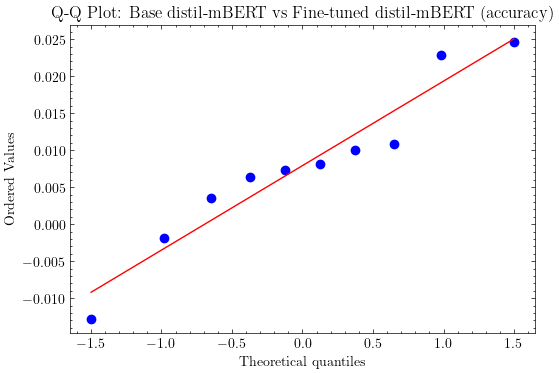

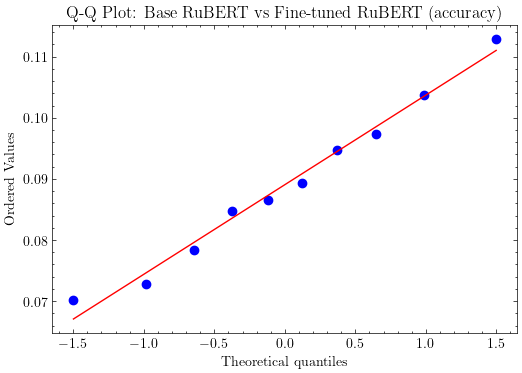

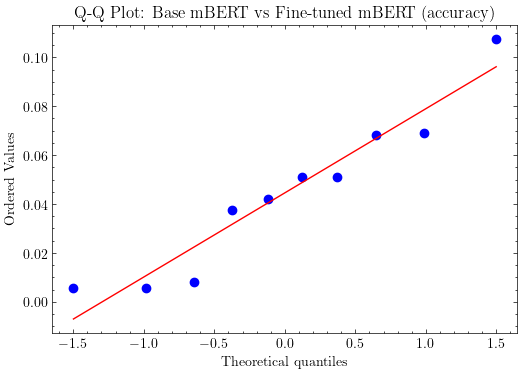

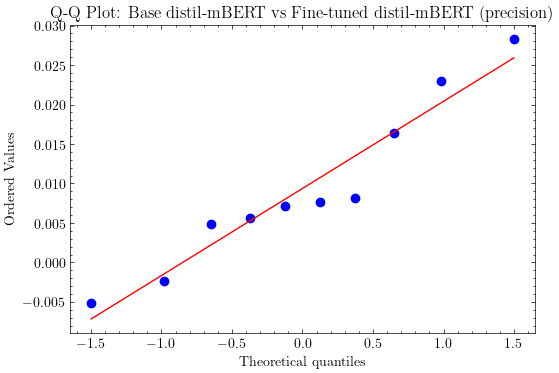

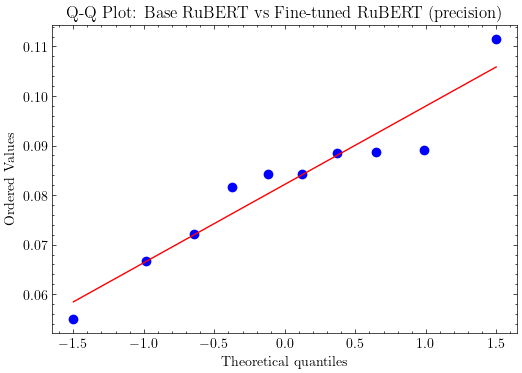

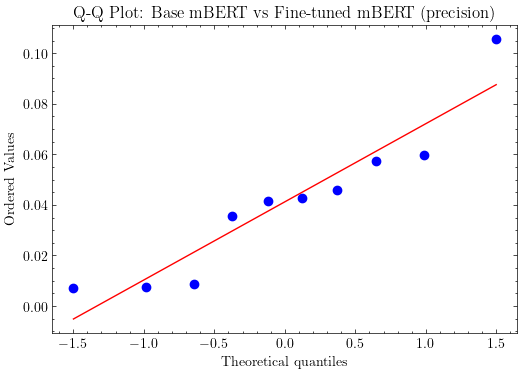

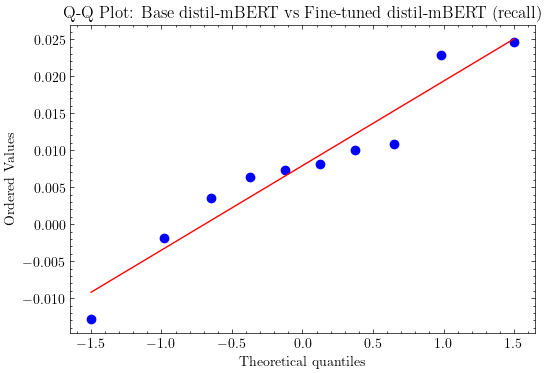

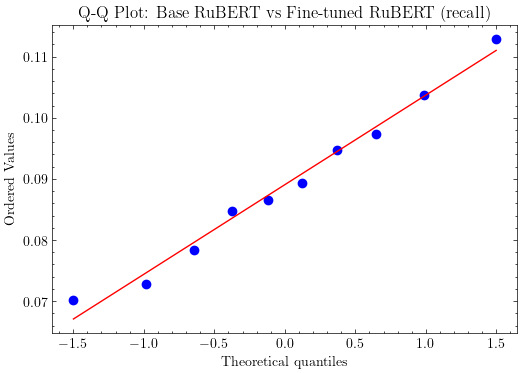

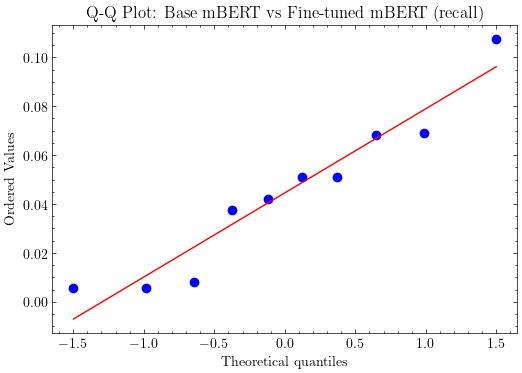

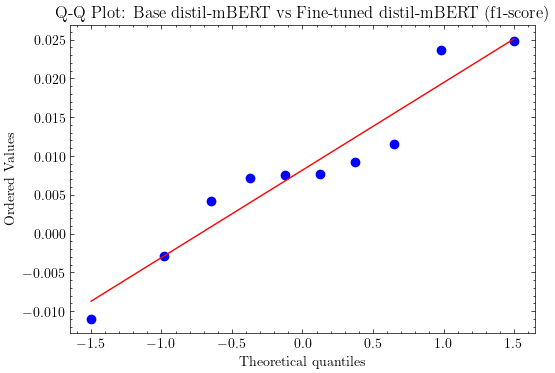

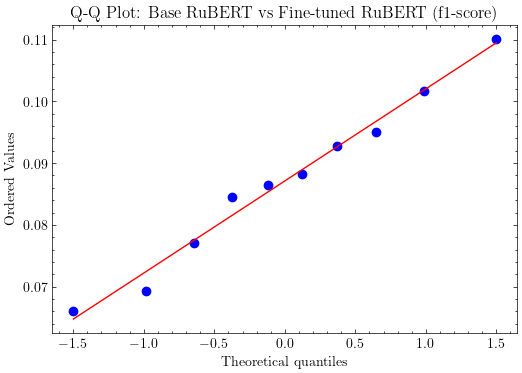

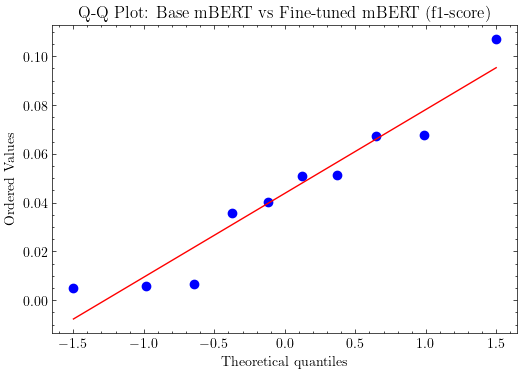

In [5]:
# Define the metrics and model pairs to compare
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
model_pairs = [
    ("Base distil-mBERT", "Fine-tuned distil-mBERT"),
    ("Base RuBERT", "Fine-tuned RuBERT"),
    ("Base mBERT", "Fine-tuned mBERT")
]

# For storing results
results = []

# Loop over each metric and model pair
for metric in metrics:
    for base_model, ft_model in model_pairs:
        # Filter data for the metric of interest
        df_metric = df[df['metric'] == metric].copy()
        
        # For metrics other than accuracy, we select the 'weighted avg' rows
        if metric != 'accuracy':
            df_metric = df_metric[df_metric['class'] == 'weighted avg']
        
        # Get the performance values for base and fine-tuned models; sort by run_number to align runs
        base_values = (df_metric[df_metric['model_name'] == base_model]
                       .sort_values("run_number")["value"].values)
        ft_values = (df_metric[df_metric['model_name'] == ft_model]
                     .sort_values("run_number")["value"].values)
        
        # Compute differences for each run: fine-tuned minus base
        differences = ft_values - base_values
        
        # Calculate descriptive statistics
        mean_diff = np.mean(differences)
        var_diff = np.var(differences, ddof=1)
        n = len(differences)
        se = np.sqrt(var_diff) / np.sqrt(n)
        # 95% CI using t-distribution
        t_crit = stats.t.ppf(0.975, df=n-1)
        ci_lower = mean_diff - t_crit * se
        ci_upper = mean_diff + t_crit * se
        
        # Paired t-test: test if mean difference is significantly different from 0
        t_stat, p_value = stats.ttest_1samp(differences, 0)
        
        # Check normality of the differences using the Shapiro-Wilk test
        shapiro_stat, shapiro_p = stats.shapiro(differences)
        
        # Optionally, display a Q-Q plot for a visual check:
        plt.style.use('science')
        plt.figure(figsize=(6,4))
        stats.probplot(differences, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot: {base_model} vs {ft_model} ({metric})")
        plt.show()
        
        # Save results
        results.append({
            "metric": metric,
            "model_pair": f"{base_model} vs {ft_model}",
            "mean_diff": mean_diff,
            "variance": var_diff,
            "95% CI": (float(ci_lower), float(ci_upper)),
            "t_statistic": t_stat,
            "p_value": p_value,
            "shapiro_p": shapiro_p
        })

In [6]:
# Display the results
for res in results:
    print(f"Metric: {res['metric']}, Model Pair: {res['model_pair']}")
    print(f"  Mean Difference: {res['mean_diff']:.4f}")
    print(f"  Variance: {res['variance']:.6f}")
    print(f"  95% CI: {res['95% CI']}")
    print(f"  t-statistic: {res['t_statistic']:.4f}, p-value: {res['p_value']:.4f}")
    print(f"  Shapiro-Wilk p-value: {res['shapiro_p']:.4f}")
    print("-" * 50)

Metric: accuracy, Model Pair: Base distil-mBERT vs Fine-tuned distil-mBERT
  Mean Difference: 0.0079
  Variance: 0.000118
  95% CI: (0.00016360440228512397, 0.015676395597714887)
  t-statistic: 2.3099, p-value: 0.0462
  Shapiro-Wilk p-value: 0.5903
--------------------------------------------------
Metric: accuracy, Model Pair: Base RuBERT vs Fine-tuned RuBERT
  Mean Difference: 0.0890
  Variance: 0.000184
  95% CI: (0.07935743454403375, 0.09874256545596623)
  t-statistic: 20.7835, p-value: 0.0000
  Shapiro-Wilk p-value: 0.9502
--------------------------------------------------
Metric: accuracy, Model Pair: Base mBERT vs Fine-tuned mBERT
  Mean Difference: 0.0446
  Variance: 0.001072
  95% CI: (0.021133807010390044, 0.06798619298960998)
  t-statistic: 4.3029, p-value: 0.0020
  Shapiro-Wilk p-value: 0.3875
--------------------------------------------------
Metric: precision, Model Pair: Base distil-mBERT vs Fine-tuned distil-mBERT
  Mean Difference: 0.0094
  Variance: 0.000109
  95% CI:

In [9]:
# 2. Filter to keep only summary rows:
#    - For accuracy, class is NaN
#    - For precision/recall/f1-score, use "weighted avg" (or "macro avg" if you prefer)
def keep_summary_rows(row):
    if row["metric"] == "accuracy":
        return True  # keep all accuracy rows
    else:
        return row["class"] == "weighted avg"

df_filtered = df[df.apply(keep_summary_rows, axis=1)]

# 3. We'll only keep these metrics in the final table
desired_metrics = ["accuracy", "precision", "recall", "f1-score"]
df_filtered = df_filtered[df_filtered["metric"].isin(desired_metrics)]

# 4. Compute the mean across the 10 runs for each (model_name, metric)
df_means = (
    df_filtered
    .groupby(["model_name", "metric"], as_index=False)["value"]
    .mean()
)

# 5. Parse the model_name into (short_name, domain_adaptation)
#    Example: "Base distil-mBERT" -> ("distil-mBERT", "Without domain adaptation")
#             "Fine-tuned mBERT" -> ("mBERT", "With domain adaptation")
def parse_model_name(name):
    if "Fine-tuned" in name:
        domain = "With domain adaptation"
    else:
        domain = "Without domain adaptation"
    
    # Extract the short name
    if "distil-mBERT" in name:
        short_name = "distil-mBERT"
    elif "mBERT" in name and "distil" not in name:
        short_name = "mBERT"
    elif "RuBERT" in name:
        short_name = "RuBERT"
    else:
        short_name = name  # fallback if something unexpected
    
    return pd.Series([short_name, domain], index=["short_model", "Adaptation"])

df_means[["short_model", "Adaptation"]] = df_means["model_name"].apply(parse_model_name)

# 6. Now we pivot so that rows = short_model, columns = (domain_adaptation, metric)
#    and values = mean 'value'
table = df_means.pivot_table(
    index="short_model",
    columns=["Adaptation", "metric"],
    values="value"
)

# 7. Reorder the top-level columns so "With domain adaptation" is first
#    and the second-level columns in the order: accuracy, precision, recall, f1-score
#    We create a list of the multi-index columns we want
domain_levels = ["With domain adaptation", "Without domain adaptation"]
metric_levels = ["accuracy", "precision", "recall", "f1-score"]

new_columns = []
for d in domain_levels:
    for m in metric_levels:
        new_columns.append((d, m))

# Reindex the columns with the new order
table = table.reindex(columns=pd.MultiIndex.from_tuples(new_columns, names=["Adaptation", "Metric"]))

# 8. (Optional) Reorder rows if you want distil-mBERT, mBERT, RuBERT in a specific order
desired_row_order = ["distil-mBERT", "mBERT", "RuBERT"]
table = table.reindex(desired_row_order)

# 9. Round for nicer display
table = table.round(2)

# 10. Print or display


In [10]:
table

Adaptation   With domain adaptation                            \
Metric                     accuracy precision recall f1-score   
short_model                                                     
distil-mBERT                   0.82      0.84   0.82     0.83   
mBERT                          0.83      0.85   0.83     0.83   
RuBERT                         0.83      0.84   0.83     0.83   

Adaptation   Without domain adaptation                            
Metric                        accuracy precision recall f1-score  
short_model                                                       
distil-mBERT                      0.82      0.83   0.82     0.82  
mBERT                             0.79      0.81   0.79     0.79  
RuBERT                            0.74      0.76   0.74     0.74

In [11]:
# 2. Filter to keep only summary rows:
#    - For accuracy, class is NaN
#    - For precision/recall/f1-score, use "weighted avg" (or "macro avg" if you prefer)
def keep_summary_rows(row):
    if row["metric"] == "accuracy":
        return True  # keep all accuracy rows
    else:
        return row["class"] == "macro avg"

df_filtered = df[df.apply(keep_summary_rows, axis=1)]

# 3. We'll only keep these metrics in the final table
desired_metrics = ["accuracy", "precision", "recall", "f1-score"]
df_filtered = df_filtered[df_filtered["metric"].isin(desired_metrics)]

# 4. Compute the mean across the 10 runs for each (model_name, metric)
df_means = (
    df_filtered
    .groupby(["model_name", "metric"], as_index=False)["value"]
    .mean()
)

# 5. Parse the model_name into (short_name, domain_adaptation)
#    Example: "Base distil-mBERT" -> ("distil-mBERT", "Without domain adaptation")
#             "Fine-tuned mBERT" -> ("mBERT", "With domain adaptation")
def parse_model_name(name):
    if "Fine-tuned" in name:
        domain = "With domain adaptation"
    else:
        domain = "Without domain adaptation"
    
    # Extract the short name
    if "distil-mBERT" in name:
        short_name = "distil-mBERT"
    elif "mBERT" in name and "distil" not in name:
        short_name = "mBERT"
    elif "RuBERT" in name:
        short_name = "RuBERT"
    else:
        short_name = name  # fallback if something unexpected
    
    return pd.Series([short_name, domain], index=["short_model", "Adaptation"])

df_means[["short_model", "Adaptation"]] = df_means["model_name"].apply(parse_model_name)

# 6. Now we pivot so that rows = short_model, columns = (domain_adaptation, metric)
#    and values = mean 'value'
table_2 = df_means.pivot_table(
    index="short_model",
    columns=["Adaptation", "metric"],
    values="value"
)

# 7. Reorder the top-level columns so "With domain adaptation" is first
#    and the second-level columns in the order: accuracy, precision, recall, f1-score
#    We create a list of the multi-index columns we want
domain_levels = ["With domain adaptation", "Without domain adaptation"]
metric_levels = ["accuracy", "precision", "recall", "f1-score"]

new_columns = []
for d in domain_levels:
    for m in metric_levels:
        new_columns.append((d, m))

# Reindex the columns with the new order
table_2 = table_2.reindex(columns=pd.MultiIndex.from_tuples(new_columns, names=["Adaptation", "Metric"]))

# 8. (Optional) Reorder rows if you want distil-mBERT, mBERT, RuBERT in a specific order
desired_row_order = ["distil-mBERT", "mBERT", "RuBERT"]
table_2 = table_2.reindex(desired_row_order)

# 9. Round for nicer display
table_2 = table_2.round(2)

# 10. Print or display
table_2

Adaptation   With domain adaptation                            \
Metric                     accuracy precision recall f1-score   
short_model                                                     
distil-mBERT                   0.82      0.79   0.82      0.8   
mBERT                          0.83      0.79   0.82      0.8   
RuBERT                         0.83      0.79   0.82      0.8   

Adaptation   Without domain adaptation                            
Metric                        accuracy precision recall f1-score  
short_model                                                       
distil-mBERT                      0.82      0.78   0.80     0.78  
mBERT                             0.79      0.74   0.77     0.75  
RuBERT                            0.74      0.68   0.70     0.68